In [1]:
matplotlib inline


data_type=face, alpha=4, N=100
t == 0.00
t == -0.54
t == -1.13
t == -1.79
t == -2.54
t == -3.32
t == -4.07
t == -4.79
t == -5.49
t == -6.16
t == -6.78
t == -7.34
t == -7.84
t == -8.32
t == -8.78
t == -9.27
t == -9.79
t == -10.42
t == -11.27
t == 0.54
t == 1.05
t == 1.53
t == 1.99
t == 2.43
t == 2.85
MAP curve computation took 6.54 sec
compute_maxent_prob took 8.849636 sec


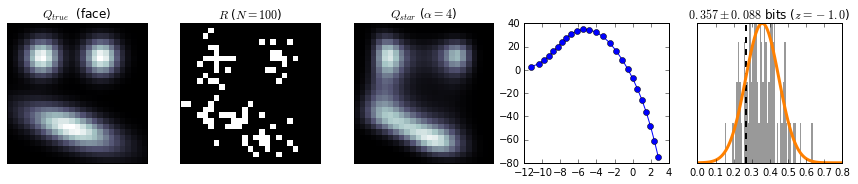

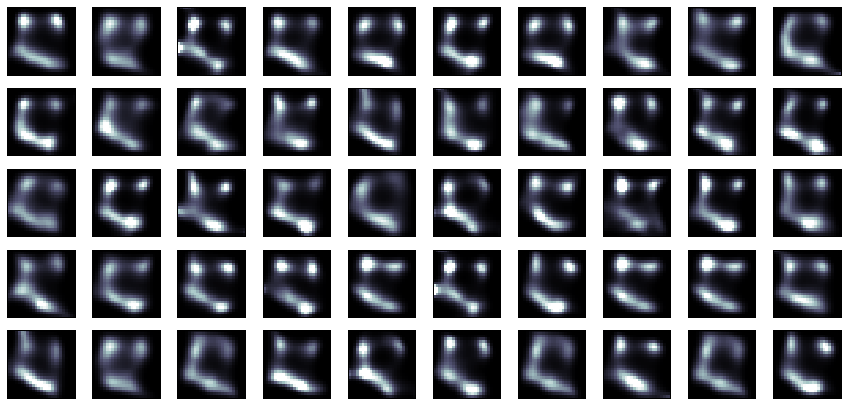

In [6]:
run test_deft_2d.py

Laplacian computed de novo
t_start == -17.90
t == -17.90
t == -18.22
t == -18.50
t == -18.75
t == -18.98
t == -17.57
t == -17.20
t == -16.76
t == -16.23
t == -15.60
t == -14.80
t == -13.86
t == -12.85
t == -11.80
t == -10.76
t == -9.74
t == -8.75
t == -7.78
t == -6.82
t == -5.86
t == -4.88
t == -3.90
t == -2.94
t == -2.03
MAP curve computation took 0.85 sec


../code/deft_core.py:717: RuntimeWarning: overflow encountered in exp
  weights = np.array([np.exp(p.log_E) for p in points_at])
../code/deft_core.py:750: RuntimeWarning: invalid value encountered in divide
  candidate_ell_probs = weights/sp.sum(weights)
../code/deft_core.py:752: RuntimeWarning: invalid value encountered in less
  size=num_samples, p=candidate_ell_probs)



wide, alpha=3


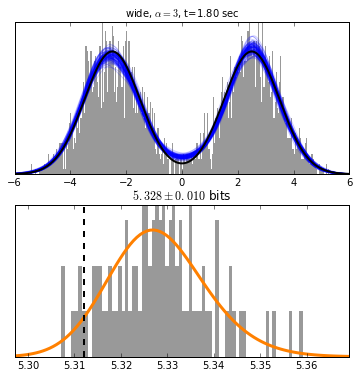

ValueError: max() arg is an empty sequence

In [5]:
run test_deft_1d_entropy_estimation.py

Laplacian computed de novo
t_start == -17.90
t == -17.90
t == -18.24
t == -18.53
t == -18.80
t == -19.03
t == -17.56
t == -17.16
t == -16.70
t == -16.17
t == -15.53
t == -14.74
t == -13.79
t == -12.74
t == -11.49
t == -9.90
t == -8.39
t == -6.91
t == -5.62
t == -4.56
t == -3.64
t == -2.75
t == -1.87
MAP curve computation took 0.68 sec

wide, alpha=3


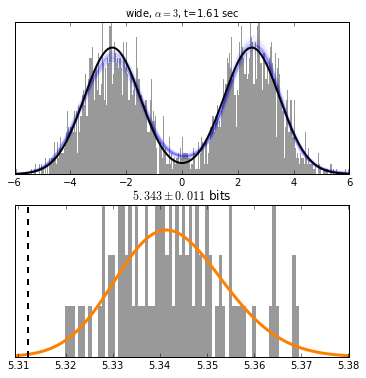

ValueError: max() arg is an empty sequence

In [8]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import time
import math

# Add parent directory to path
import sys
sys.path.append('../code/')
sys.path.append('../sim/')


# Import deft modules
import deft_1d
import simulate_data_1d
import utils

plt.close('all')

# Generate data
N = 3000
G = 300
eG = 100
alpha = 3
data_type = 'wide'

# Colors to use
blue = [0.,0.,1.]
lightblue = [0.0, 0.5, 1.0]
orange = [1.,0.5,0.]
gray = [0.6, 0.6, 0.6]


# Simulate data and get default deft settings
data, defaults = simulate_data_1d.run(data_type,N)

# Get bounding box
bbox = [defaults['box_min'], defaults['box_max']]

#
# Do DEFT density estimation
#

results = deft_1d.run(data, G=G, alpha=alpha, \
    bbox=bbox, \
    periodic=False,
    num_samples=100,
    print_t=True)

# Provide feedback
print '\n%s, alpha=%d'%(data_type, alpha)

# Compute true density
xs = results.bin_centers
Q_true = np.zeros(G)
for i, x in enumerate(xs):
    Q_true[i] = eval(defaults['pdf_py'])
Q_true /= results.h*sum(Q_true)

#
# Estimate entropy
#

# Compute the entropy of the sampled densities
Qs = results.Q_samples*results.h
num_samples = Qs.shape[1]
entropies = sp.array([sp.stats.entropy(Qs[:,i]) for i in range(num_samples)])

true_e = sp.stats.entropy(Q_true*results.h)

# Make sure all entropies are finite
assert all(np.isfinite(entropies))

ebox = [0,sp.log(G)]
mean_e = np.mean(entropies)
std_e = np.std(entropies)

# Adjust ebox to data
ebox[0] = max(0, min(entropies)-1*std_e)
ebox[0] = min(ebox[0], true_e)
ebox[1] = min(ebox[1], max(entropies)+1*std_e)
ebox[1] = max(ebox[1], true_e)
eh, es, e_edges = utils.grid_info_from_bbox_and_G(ebox, eG)
eR, _ = utils.histogram_counts_1d(entropies, G=eG, bbox=ebox, normalized=True)

# Now do density estimation for the entropies
eresults = deft_1d.run(entropies, G=eG, bbox=ebox, alpha=3, periodic=False, num_samples=0)

########

# Plot histogram with density estimate on top
plt.figure(figsize=[6, 6])

#
# Show densitye estimates
#
ax = plt.subplot(2,1,1)

# Plot histogram density
left_bin_edges = results.bin_edges[:-1]
plt.bar(left_bin_edges, results.R, \
    width=results.h, linewidth=0, color=gray, zorder=0)

# Plot error bars on density estimate
#plt.fill_between(results.bin_centers,
#    results.Q_ub, results.Q_lb, color=lightblue, 
#    zorder=1, alpha=0.5, linewidth=0)

# Plot deft density estimate
plt.plot(xs, results.Q_samples, \
    color=blue, linewidth=.1, alpha=0.2, zorder=2)

# Plot the true density
plt.plot(xs, Q_true, color='k', linewidth=2)

# Tidy up the plot
plt.yticks([])
#plt.xticks([])
plt.ylim([0, 1.2*max(results.Q_star)])
plt.xlim(results.bbox)
t = results.deft_1d_compute_time
plt.title("%s, $\\alpha = %d$, t=%1.2f sec"%(data_type, alpha, t), \
    fontsize=10)

#
# Show entropy estimate
# 
plt.subplot(2,1,2)

left_e_edges = e_edges[:-1]
plt.bar(left_e_edges, eR, width=eh, linewidth=0, color=gray, zorder=0)
plt.xlim(ebox)

plt.plot(eresults.bin_centers, eresults.Q_star, color=orange, linewidth=3)

yl = [0, 1.2*max(eresults.Q_star)]
plt.plot([true_e, true_e], yl, '--k', linewidth=2)
plt.ylim(yl)
plt.yticks([])
plt.title("$%.3f \\pm %.3f$ bits"%(mean_e, std_e))

# Plotting incantation
plt.ion() # So focus goes back to commandline
plt.draw() # Needed to avoid "CGContextRef is NULL" exception
plt.show()
plt.tight_layout() # Needed so plot is drawn tollerably

# Save plot
plt.savefig('report.test_deft_1d.png')